In [1]:
import pandas as pd
import numpy as np


# pymc3 with theano backend
import pymc3 as pm
import theano.tensor as tt

import scipy.stats as stats
import matplotlib.pyplot as plt

import datetime
import collections

# finance data from yahoo finance
import yfinance as yf


In [2]:
# modify figure size
from IPython.core.pylabtools import figsize

# define fonts

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 19}

plt.rc('font', **font)

# Stock information

https://www.nasdaq.com/market-activity/stocks/screener

In [3]:
# finance
fin = ["IDCBY",
"HSBC",
"C",
"V",
"JPM",
"MA",
"BAC",
"IDCBF"]

# Healthcare
health = ["JNJ",
"RHHVF",
"NVS",
"MRK",
"PFE",
"ABT",
"BMY",
"MDT" ]

# Consumer goods
cons = ["AAPL",
"NSRGF",
"PG",
"PEP",
"TSM",
"INTC",
"KO",
"LVMUY"]

# Services
srv = ["AMZN",
"NFLX",
"WMT",
"UNH",
"HD",
"DIS",
"CMCSA",
"CHLKF"]

# Utilities
util = ["CVX",
"NEE",
"IBDRY",
"OJSCY",
"DUK",
"D",
"SO",
"AEP"]

#TECH
tech = ["MSFT",
"GOOGL",
"FB",
"VOD",
"ACN",
"T",
"CHT",
"VZ"]

# Industrial goods
ind = ["UTX",
"HON",
"LMT",
"EADSY",
"GE",
"SIEGY",
"MMM",
"CAT"]

# Random
others = ["XOM",
"BUD",
"NVO",
"BA",
"USB",
"IBM",
"ORCL",
"WFC"]

In [10]:
# combine stock information
stocks = fin+health+srv+ind+cons+util+tech+others

stock_dict = {'HEALTH':health,'IND':ind, 'UTIL':util,'FINANCE':fin,'TECH':tech,'SERVICE':srv,'CONSUM':cons,'OTHERS':others}

# choose colors for the plots
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821","#345eeb", "#eb8f34", "#57514b", "#10d4de"]

stock_closes = pd.DataFrame()

In [11]:
enddate = "2019-02-22" #  ends one year ago 
startdate = '2014-1-1'

In [12]:
n_observations = 100 

In [13]:
# fetch stock information
for stock in stocks:
    tickerData = yf.Ticker(stock)
    x = tickerData.history(period='1d', start=startdate, end=enddate)
    stock_series = pd.Series(x['Close'].astype(float), name=stock)
    stock_closes[stock] = stock_series

In [14]:
# normalization by delta percentage
stock_returns = stock_closes.pct_change()[1:][-n_observations:]

# list the stock indices
stock_returns.columns

Index(['IDCBY', 'HSBC', 'C', 'V', 'JPM', 'MA', 'BAC', 'IDCBF', 'JNJ', 'RHHVF',
       'NVS', 'MRK', 'PFE', 'ABT', 'BMY', 'MDT', 'AMZN', 'NFLX', 'WMT', 'UNH',
       'HD', 'DIS', 'CMCSA', 'CHLKF', 'UTX', 'HON', 'LMT', 'EADSY', 'GE',
       'SIEGY', 'MMM', 'CAT', 'AAPL', 'NSRGF', 'PG', 'PEP', 'TSM', 'INTC',
       'KO', 'LVMUY', 'CVX', 'NEE', 'IBDRY', 'OJSCY', 'DUK', 'D', 'SO', 'AEP',
       'MSFT', 'GOOGL', 'FB', 'VOD', 'ACN', 'T', 'CHT', 'VZ', 'XOM', 'BUD',
       'NVO', 'BA', 'USB', 'IBM', 'ORCL', 'WFC'],
      dtype='object')

In [15]:
# reduce autocorrelation by thinning data 
blocks = 5
block_dict = {}
for n in range(blocks):
    idx = [(it * blocks)+n for it in range(stock_returns.shape[0]// blocks) ]
    
    block_dict[n] = stock_closes.iloc[idx]

In [16]:
# choose a block for preparation
prep_stock = block_dict[2]

In [17]:
def cov_to_corr(A):
    """
    Transform covariance to correlation
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    return A

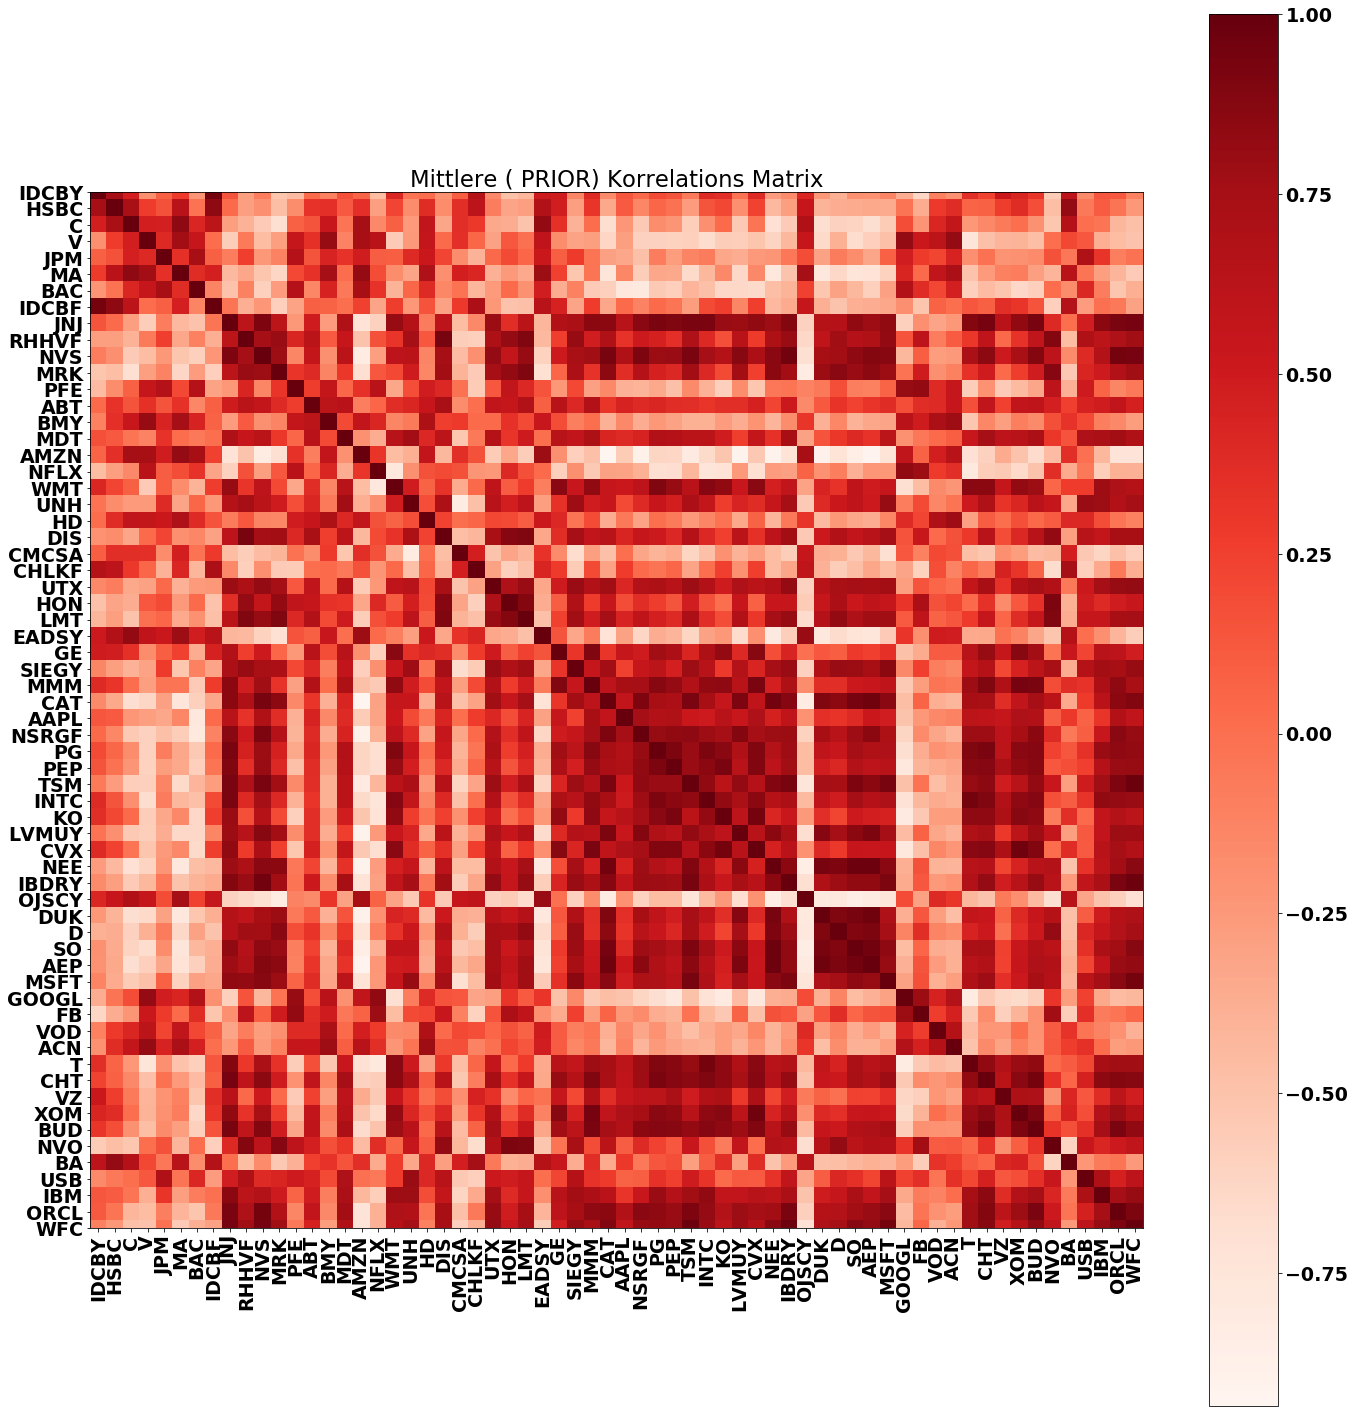

In [27]:
# plot the 
#plt.subplot(1,2,1)
figsize(20,20)

plt.imshow(cov_to_corr(np.asarray(prep_stock.cov())) , interpolation="none", 
                cmap = "Reds") 
plt.xticks(np.arange(64), stock_returns.columns,rotation='vertical')
plt.yticks(np.arange(64), stock_returns.columns)
plt.colorbar(orientation="vertical")
plt.title("Mittlere ( PRIOR) Korrelations Matrix")

plt.tight_layout();

In [19]:
# estimate topical priors
prior_expectations = {}
for ind, stocks in stock_dict.items():#[health,ind, util,fin,tech,srv,cons,others]:
    prior_expectations[ind] = (stock_returns[stocks].mean(axis=1).mean() , stock_returns[stocks].mean(axis=1).std())
    

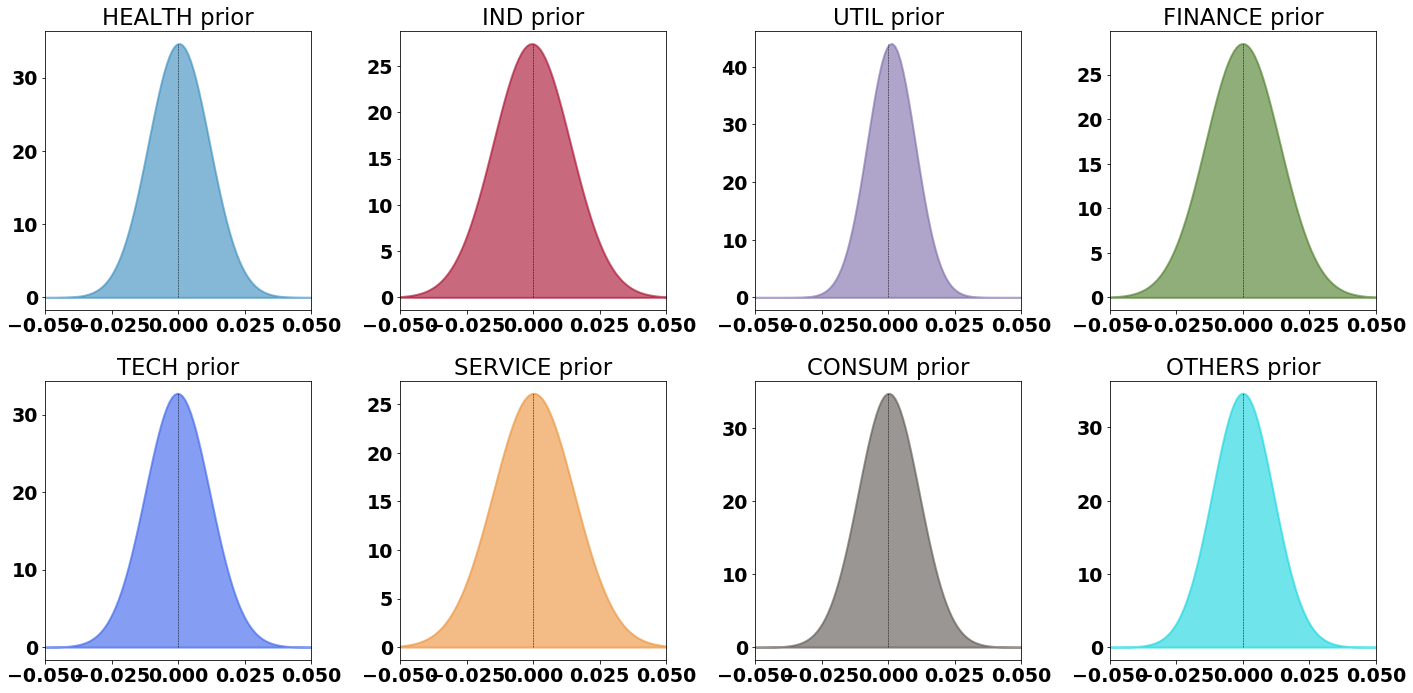

In [20]:
figsize(20,10)

x = np.linspace(-0.05, 0.05, 100)



for i, (name, params) in enumerate(prior_expectations.items()):
    plt.subplot(2, 4, i+1)
    y = stats.norm.pdf(x, params[0], scale = params[1])
    #plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color = colors[i], linewidth=2,
                     edgecolor = colors[i], alpha = 0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k","--", linewidth = 0.5)
    plt.xlim(-0.05, 0.05)
plt.tight_layout()

In [21]:
import random
def select_stocks(returnrandom = True, combination = [0,0,0,0,0,0,0,0]  ):
    """
    Choose either a random set of stocks from each category
    Or feed a combinationlist
    """
    stock_chosen = []
    priormus = [] #np.array([x[0] for x in expert_prior_params.values()])
    priorstd = [] #np.array([x[1] for x in expert_prior_params.values()])
    
    if returnrandom:
        selected_stock = []
        for key, val in stock_dict.items():
            #print(key,prior_expectations[key], random.choice(val) )
            choice = random.choice(val)
            selected_stock.append(choice)
            stock_chosen.append(choice)
            priormus.append(prior_expectations[key][0])
            priorstd.append(prior_expectations[key][1])
        stock_relevant = stock_returns[stock_chosen]
        covar = stock_relevant.cov()
    
    
    else:
        for i, (key, val) in enumerate(stock_dict.items()):
            stock_chosen.append(val[combination[i] ])
            priormus.append(prior_expectations[key][0])
            priorstd.append(prior_expectations[key][1])
        
        stock_relevant = stock_returns[stock_chosen]
        covar = stock_relevant.cov()
        return stock_relevant, np.asarray(covar), np.array(priormus), np.array(priorstd)
        
    
    
    return stock_relevant, np.asarray(covar), np.array(priormus), np.array(priorstd), selected_stock

In [22]:
stocks_chosen, init, prior_mu, prior_std = select_stocks(returnrandom = False,combination =[0,0,0,0,0,0,0,0])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


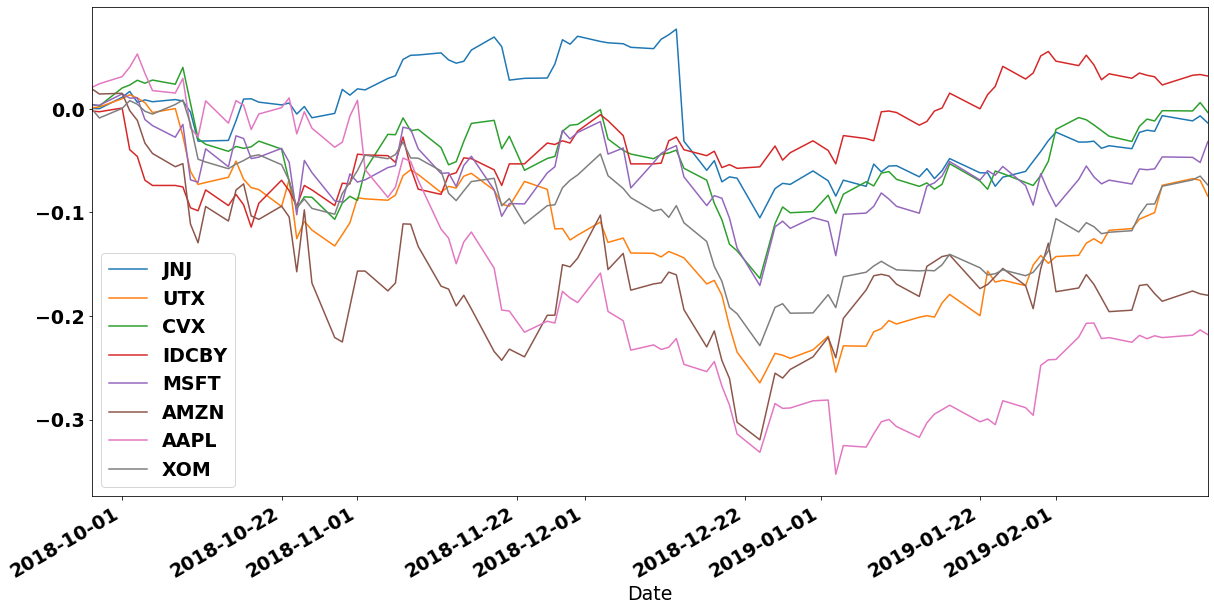

In [23]:

# plot timelines for stock behavior
figsize(20,10)
cum_returns = np.cumprod(1 + stocks_chosen) - 1
cum_returns.index = stocks_chosen.index
cum_returns.plot()

In [24]:
# analyze posterior 
with pm.Model() as model:
    
    covar = pm.WishartBartlett('covar', np.diag(prior_std**2), nu=20, testval=init)
    
    mu = pm.Normal('returns', mu=prior_mu, sd=1, shape= prior_mu.shape[0] )

    obs = pm.MvNormal('observed returns', mu=mu, cov = covar, observed=stocks_chosen)
    
    step = pm.NUTS()
    trace = pm.sample(5000, step=step)


Added new variable covar_c to model diagonal of Wishart.
Added new variable covar_z to model off-diagonals of Wishart.
/home/ethuer/anaconda3/envs/deeplearning36/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/ethuer/anaconda3/envs/deeplearning36/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/ethuer/anaconda3/envs/deeplearning36/lib/python

/home/ethuer/anaconda3/envs/deeplearning36/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/ethuer/anaconda3/envs/deeplearning36/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


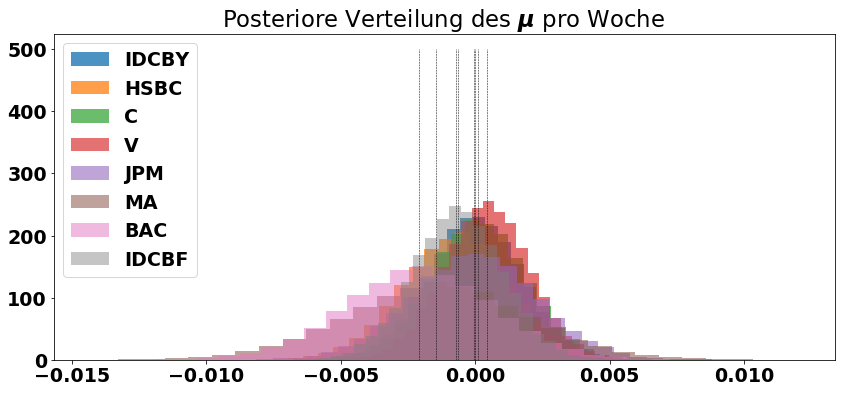

In [25]:
# Visualize posterior

figsize(14,6)

#examine the mean return first.
mu_samples = trace["returns"]

for i in range(8):
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", normed=True, 
             label = "%s" % stock_returns.columns[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth = .5)

plt.title("Posteriore Verteilung des $\mu$ pro Woche ")
plt.legend();

/home/ethuer/anaconda3/envs/deeplearning36/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


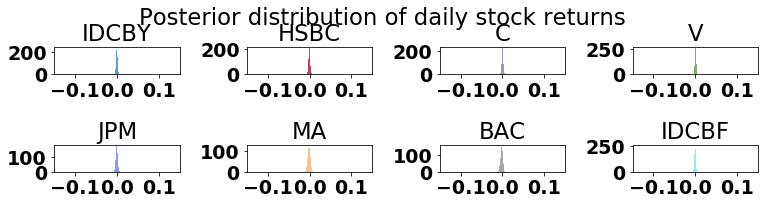

In [26]:
# posterior divergence
figsize(11.0,3)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", normed=True, color = colors[i],
             label = "%s" % stock_returns.columns[i])
    plt.title("%s" % stock_returns.columns[i])
    plt.xlim(-0.15, 0.15)
    
plt.suptitle("Posterior distribution of daily stock returns")
plt.tight_layout()

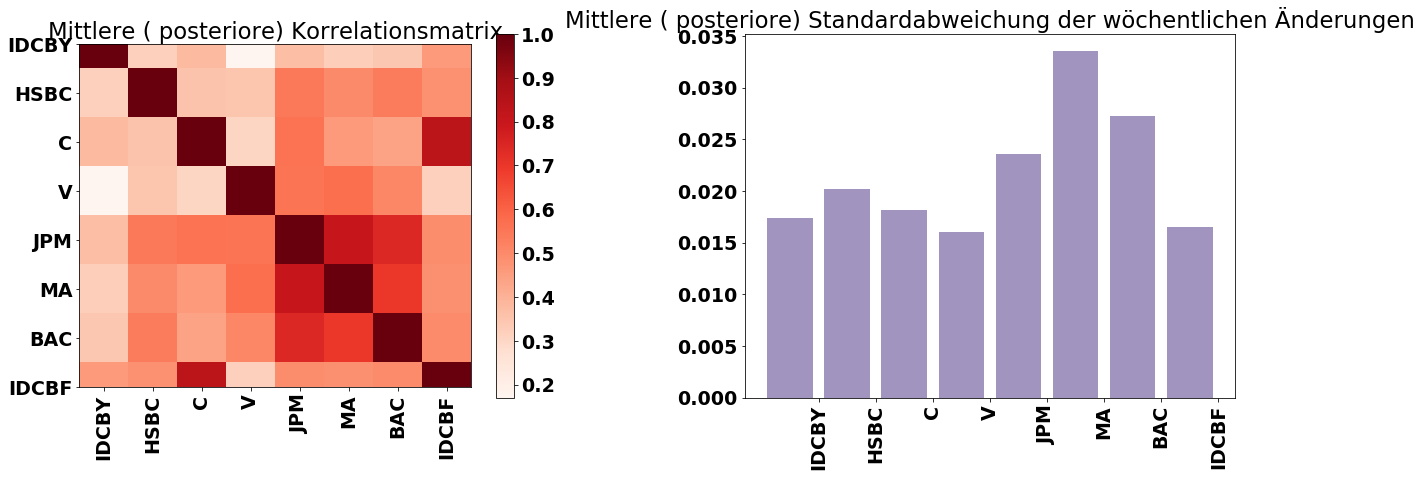

In [32]:
figsize(20,7)
cov_samples = trace["covar"]
mean_covariance_matrix = cov_samples.mean(axis=0)

def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A


plt.subplot(1,2,1)
plt.imshow(cov2corr(mean_covariance_matrix) , interpolation="none", 
                cmap = "Reds") 
plt.xticks(np.arange(8), stock_returns.columns,rotation='vertical')
plt.yticks(np.arange(8), stock_returns.columns)
plt.colorbar(orientation="vertical")
plt.title("Mittlere ( posteriore) Korrelationsmatrix")

plt.subplot(1,2,2)
plt.bar(np.arange(8), np.sqrt(np.diag(mean_covariance_matrix)),
        color = colors[2], alpha = 0.7)
plt.xticks(np.arange(8) + 0.5, stock_returns.columns,rotation='vertical');
plt.title("Mittlere ( posteriore) Standardabweichung der wöchentlichen Änderungen")

plt.tight_layout();